In [48]:
import os
import os.path as osp
import pprint
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt
import scipy.io as sio

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.models.HT import hough_transform

from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to
import cv2
from IPython.display import Image, display

In [108]:
REJECT_DEGREE_TH = 40.0

In [50]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [51]:
def c(x):
    return sm.to_rgba(x)

In [52]:
config_file = "config/wireframe.yaml"
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'outdir': 'results/',
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 20000,
              'vote_index': 'vote_index_128_128_3_1.mat'},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 5,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
            

In [53]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_name = "cpu"
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(0)
print("Let's use", torch.cuda.device_count(), "GPU(s)!")

Let's use 0 GPU(s)!


In [54]:
device = torch.device(device_name)
checkpoint = torch.load("pretrained_models/ht_lcnn/checkpoint.pth.tar", map_location=device)


In [55]:
# Load model
if os.path.isfile(C.io.vote_index):
    vote_index = sio.loadmat(C.io.vote_index)['vote_index']
else:
    vote_index = hough_transform(rows=128, cols=128, theta_res=3, rho_res=1)
    sio.savemat(C.io.vote_index, {'vote_index': vote_index})
vote_index = torch.from_numpy(vote_index).float().contiguous().to(device)
print('load vote_index', vote_index.shape)

load vote_index torch.Size([128, 128, 182, 60])


In [56]:
model = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
    vote_index=vote_index,

)
model = MultitaskLearner(model)
model = LineVectorizer(model)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

LineVectorizer(
  (backbone): MultitaskLearner(
    (backbone): HourglassNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck2D(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (layer2): Sequential(
        (0): Bottleneck2D(
          (bn

In [57]:
img = "pictures/01.png"
print(f"Processing {img}")
im = skimage.io.imread(img)
# cv2.imshow("img",im)
# cv2.waitKey(0) 
# display(Image(im))

Processing pictures/01.png


In [58]:
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
image = (im_resized - M.image.mean) / M.image.stddev
# cv2.imshow("img",image)
# cv2.waitKey(0) 
image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()

In [59]:
# cv2.imshow("img",image)
# cv2.waitKey(0) 

In [60]:
with torch.no_grad():
    input_dict = {
        "image": image.to(device),
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    H = model(input_dict)["preds"]

In [61]:
lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
scores = H["score"][0].cpu().numpy()
print('lines: ',lines, ', scores: ', scores)
for i in range(1, len(lines)):
    if (lines[i] == lines[0]).all():
        lines = lines[:i]
        scores = scores[:i]
        break

lines:  [[[ 296.62046313 1357.41897583]
  [ 236.12358749 1367.06737518]]

 [[ 714.98130798 1775.24139404]
  [ 194.94132042 1183.35033417]]

 [[ 703.05009127  216.47910118]
  [ 199.05102253  791.38790131]]

 ...

 [[ 710.62550783 1566.69296265]
  [ 229.62587178 1160.1531601 ]]

 [[ 194.3230176  1537.28645325]
  [ 296.77264094 1444.86156464]]

 [[ 286.34405136 1416.77570343]
  [ 237.59344876 1627.06581116]]] , scores:  [0.99956626 0.9995142  0.99944407 ... 0.8604378  0.86006624 0.8591204 ]


In [62]:

# postprocess lines to remove overlapped lines
diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

In [113]:
print(nlines[0])
# sorted(nlines, key=lambda x: x[0])

[[ 296.62046313 1357.41897583]
 [ 236.12358749 1367.06737518]]


In [63]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

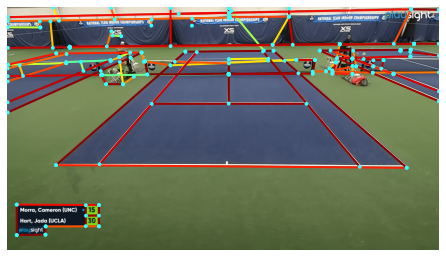

In [64]:
t = 0.94
im2 = np.copy(im)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
    cv2.line(im2, (int(a[1]), int(a[0])), (int(b[1]), int(b[0])), (255, 255, 255), thickness=2)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()


In [65]:
cv2.imshow("OutputImage", im2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('pictures/test.jpg', im2)


True

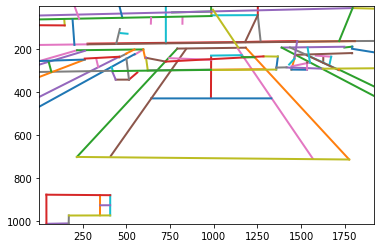

In [66]:
t = 0.94
plt.figure(1)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
plt.gca().invert_yaxis()
plt.show()
plt.close()

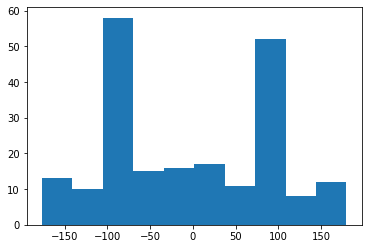

In [67]:
line_w_thetas = []
thetas=[]
for line in nlines:
    if line[0][1]<line[1][1]:
        dy = line[0][1]-line[1][1]
        dx = line[0][0]-line[1][0]
    else:
        dy = line[1][1]-line[0][1]
        dx = line[1][0]-line[0][0]        

    theta = math.atan2(dy,dx)
    theta *= 180/math.pi
    line_w_thetas.append([line,theta])
    thetas.append(theta)
    # print (theta)
thetas.sort()
# print(thetas)
# np.gradient(thetas)
result = plt.hist(thetas)

In [68]:
line_w_thetas[0][0]

array([[ 296.62046313, 1357.41897583],
       [ 236.12358749, 1367.06737518]])

In [101]:
res = np.copy(result[0])
print(res)
ind1=np.argmax(res)
res[ind1] =0
ind2 = np.argmax(res)
print(ind1,ind2)
print(result[1][ind1],result[1][ind2])
filter_th = [int(result[1][ind1]),int(result[1][ind2])]
print(filter_th)


[13. 10. 58. 15. 16. 17. 11. 52.  8. 12.]
2 7
-105.35458055006875 72.90761360464288
[-105, 72]


In [70]:
intersect_points = []
for i in range(len(nlines)):
    for j in range(i+1,len(nlines)):
        inter = get_intersect(nlines[i][0],nlines[i][1],nlines[j][0],nlines[j][1])
        if abs(inter[1])< im.shape[0] and abs(inter[0])< im.shape[1]:
            intersect_points.append(inter)

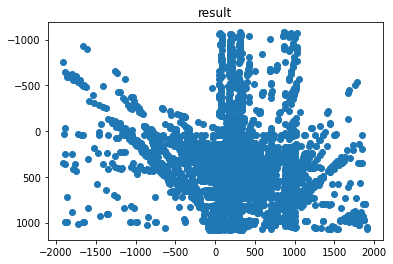

In [71]:
plt.title('result')
plt.scatter([i[0] for i in intersect_points],[i[1] for i in intersect_points])
plt.gca().invert_yaxis()
# plt.imshow(im)

In [72]:
def add_court_overlay(frame, homography, overlay_color=(255, 255, 255)):
    court_reference = cv2.imread("pictures/court_reference.png", 0)
    court = cv2.warpPerspective(court_reference, homography, frame.shape[1::-1])
    frame[court == 255, :] = overlay_color
    return frame

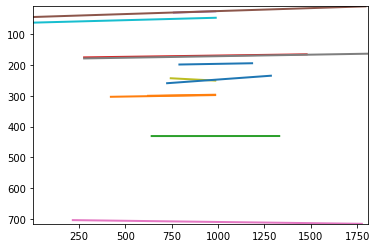

In [73]:
plt.figure(1)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
            ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
        plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
plt.gca().invert_yaxis()
 

In [74]:
# t = 0.94
# plt.gca().set_axis_off()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0, 0)

# new_nlines = np.zeros((2,2,2))
# new_nscores = np.zeros((2))
# bottom_1 = -1
# bottom_2 = -1
# for (a, b), s in zip(nlines, nscores):
#     if s < t:
#         continue
    
#     # is horizontal
#     # has a point in the middle of the image
#     if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
#             ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
#         min_bottom = min(bottom_1, bottom_2)
#         if a[0] > min_bottom and b[0] > min_bottom:
#             if(bottom_1 == min_bottom):
#                 bottom_1 = (a[0]+b[0])/2
#                 new_nlines[0][0] = a
#                 new_nlines[0][1] = b
#                 new_nscores[0] = s
#             else:
#                 bottom_2 = (a[0]+b[0])/2
#                 new_nlines[1][0] = a
#                 new_nlines[1][1] = b
#                 new_nscores[1] = s

# court_points = new_nlines.copy()
# if(court_points[0][0][0] > court_points[1][0][0]):
#     court_points = np.flip(court_points, 0)
# for i, p in enumerate(court_points):
#     court_points[i] = np.flip(court_points[i], 1)
# for i, p in enumerate(court_points):
#     court_points[i] = p[p[:, 0].argsort()]
# # print(court_points)
# court_points = court_points.reshape(-1, new_nlines.shape[-1])

# court_points_new = court_points

# print("----------------------------")
# print(court_points)
# print(court_points_new)
# print("----------------------------")

# template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
# # T, _, _ = best_fit_transform(template_points, court_points)
# T, status = cv2.findHomography(template_points, np.asarray(court_points_new))
# plt.imshow(im)
# plt.show()
# plt.imshow(T)
# plt.show()
# court = add_court_overlay(im, T, overlay_color=(255, 0, 0))
# for c in court_points_new:
#     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
# # court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
# plt.imshow(court)
# plt.show()

In [75]:
def GetVanishingPoint(Lines):
    # We will apply RANSAC inspired algorithm for this. We will take combination 
    # of 2 lines one by one, find their intersection point, and calculate the 
    # total error(loss) of that point. Error of the point means root of sum of 
    # squares of distance of that point from each line.
    VanishingPoint = None
    MinError = 100000000000

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)

                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

In [76]:
def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line

        # Calculating equation of the line: y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2
        # theta will contain values between -90 -> +90. 
        theta = math.degrees(math.atan(m))

        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    
    # Removing extra lines 
    # (we might get many lines, so we are going to take only longest 15 lines 
    # for further computation because more than this number of lines will only 
    # contribute towards slowing down of our algo.)
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    
    return FinalLines

In [104]:
def FilterLines2(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line[0]
        theta = Line[1]
        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if  filter_th[0]-REJECT_DEGREE_TH<= theta <=filter_th[0]+REJECT_DEGREE_TH \
        or filter_th[1]-REJECT_DEGREE_TH<= theta <=filter_th[1]+REJECT_DEGREE_TH:
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, theta, l])

    
    return FinalLines

In [86]:
print(line_w_thetas[0][0])
[[x1, y1], [x2, y2]] = line_w_thetas[0][0]
print(x1,y1,x2,y2)

[[ 296.62046313 1357.41897583]
 [ 236.12358749 1367.06737518]]
296.6204631328583 1357.4189758300781 236.1235874891281 1367.0673751831055


In [109]:
LineSS = FilterLines2(line_w_thetas)
print(LineSS[0])

[714.9813079833984, 1775.2413940429688, 194.94132041931152, 1183.3503341674805, 48.697214535193936, 787.8937843555974]


In [80]:
# Get vanishing point

LinesS = FilterLines(nlines)
VanishingPoint = GetVanishingPoint(nlines)

# Checking if vanishing point found
if VanishingPoint is None:
    print("Vanishing Point not found. Possible reason is that not enough lines are found in the image for determination of vanishing point.")



IndexError: index 4 is out of bounds for axis 0 with size 2

In [110]:
# Drawing lines and vanishing point
im3 = np.copy(im)
lines32 = np.float32(LineSS)
print(lines32[0])
for Line in lines32:
    cv2.line(im3, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
# cv2.circle(im3, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

# Showing the final image
cv2.imshow("OutputImage", im3)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ 714.9813   1775.2415    194.94131  1183.3503     48.697216  787.8938  ]


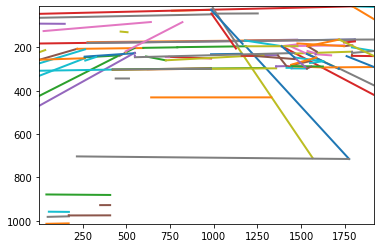

In [111]:
# Drawing lines and vanishing point
plt.figure(2)
plt.margins(0, 0)
lines32 = np.float32(LineSS)
for Line in lines32:
    # cv2.line(im, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
    plt.plot((Line[1], Line[3]), (Line[0], Line[2]), linewidth=2)
# plt.scatter(VanishingPoint[0], VanishingPoint[1],**PLTOPTS)    
    # Showing the final imageplt.gca().invert_yaxis()
plt.gca().invert_yaxis()

In [ ]:
GrayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#Blurring image to reduce noise.
BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
# Generating Edge image
EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

# Finding Lines in the image
Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

In [ ]:
for Line in Lines:
    Line = Line[0]
    cv2.line(im,(Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
# cv2.circle(im, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)
cv2.imshow("OutputImage", im)
cv2.waitKey(0)
cv2.destroyAllWindows()